In [1]:
from scipy import stats
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

In [2]:
continuous = pd.read_csv("data/continuous_sport_dataset.csv")
original = pd.read_stata("../dati/td_ita.dta")
categorical = pd.read_csv("data/categorical_sport_dataset.csv")
sport_eve = pd.read_csv("data/sport_activity_sessions_collapsed.csv").drop(columns="Unnamed: 0")
sport_eve.id = sport_eve.id.astype(int)
sport_eve.start_time, sport_eve.end_time = pd.to_datetime(sport_eve.start_time), pd.to_datetime(sport_eve.end_time)

In [3]:
# this is just for visualization.
nuovo = pd.read_stata("../dati/td_ita.dta")
nuovo = nuovo[nuovo['first2w'].isin(['First two weeks'])]
nuovo = nuovo[['id', 'date_not','what', 'withw', 'where']]
nuovo.id = nuovo.id.astype(int)
nuovo = nuovo[(nuovo['what'] == 'Sport')  |  (nuovo['what'] == 'Walking')] 
sport_eve = nuovo
sport_eve['date_not'] = pd.to_datetime(sport_eve['date_not'])

In [4]:
# Building a way to check from code what weekday it was and storing weekends 
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0, 7):
    dictdays[i] = weekdays[i]

#list of weekend days in calendar time
weekend_clock_days = [14, 15, 21, 22, 28]

for day in weekend_clock_days:
    weekday = weekdays[sport_eve[sport_eve.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")

The date 14 was a Sat
The date 15 was a Sun
The date 21 was a Sat
The date 22 was a Sun
The date 28 was a Sat


In [5]:
sport_eve

,id,date_not,what,withw,where
69,0,2020-11-14 10:30:00,Walking,Partner,Countryside/mountain/hill/beach
72,0,2020-11-14 12:00:00,Walking,Partner,Countryside/mountain/hill/beach
73,0,2020-11-14 12:30:00,Walking,Partner,Countryside/mountain/hill/beach
75,0,2020-11-14 13:30:00,Walking,Partner,Countryside/mountain/hill/beach
76,0,2020-11-14 14:00:00,Walking,Partner,Countryside/mountain/hill/beach
...,...,...,...,...,...
266758,265,2020-11-23 16:00:00,Walking,Alone,In the street
266809,265,2020-11-24 17:30:00,Walking,Relative(s),In the street
266857,265,2020-11-25 17:30:00,Walking,Partner,In the street
267569,266,2020-11-17 08:30:00,Sport,Alone,Home apartment /room


# Filling in the missing, inactive status data

In [6]:
def today_or_yesterday(t): 
    if t.hour < 5:
        return days[t.day - 1]
    else:
        return days[t.day]

days = dict()
for i in range(sport_eve.date_not.dt.day.min(), sport_eve.date_not.dt.day.max() + 2 ):
    days[i-1] = i - sport_eve.date_not.dt.day.min()  

min_range = pd.date_range(start="2020-11-13 00:00:00", end="2020-11-30 23:59:59", freq='30T')
results = pd.DataFrame()
for user in sport_eve.id.unique():
    subset = sport_eve[sport_eve.id == user]
    complete_data = pd.DataFrame({'date_not': min_range})
    merged_df = pd.concat([complete_data, subset])
    merged_df['id'] = merged_df['id'].fillna(user)
    
    merged_df = merged_df.sort_values(by="what", na_position='first', ascending=False).drop_duplicates(keep='last', subset='date_not')
    
    merged_df['what'] = merged_df['what'].astype(str)
    merged_df['what'] = merged_df['what'].replace("nan", "Inactive")
    
    if merged_df.date_not.min() != complete_data.date_not.min() or merged_df.date_not.max() != complete_data.date_not.max():
        print()
        print(f"Some mistake occurred. \nThe amount of observation time is different than expected.\nUser: {user}, dates: {merged_df.date_not.min(), merged_df.date_not.max()}")
        print()
    if merged_df.shape[0] != complete_data.shape[0]: 
        print()
        print(f"Some mistake occurred. \nThe amount rows is different than expected.\nUser: {user}, length: {merged_df.shape[0]}, expected: {complete_data.shape[0]}")
        print()
    
    results = pd.concat([results, merged_df], ignore_index=True)
results['day'] = [today_or_yesterday(time) for time in results.date_not]

In [7]:
results.shape[0] #final result
complete_data.shape[0]*len(sport_eve.id.unique())   #total time any user has available during the experiment x n users
sport_eve.shape[0] #total each user had walked and did sports x n users
results.shape[0] - complete_data.shape[0]*len(sport_eve.id.unique())

# CHECK: EVERY HOUR (in a 24 day representing all the observation time) SHOULD HAVE THE SAME LENGTH.
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
experiment = results
experiment['hour'] = experiment['date_not'].dt.hour - 5
experiment['hour'] = [today_or_yesterday(hour) for hour in experiment['hour']]

total = []
for hour in experiment['hour'].unique():
    total.append(sum(experiment[experiment['hour']==hour][['what']].value_counts().sort_values()))
print(total)    

[7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092]


In [8]:
results

,date_not,id,what,withw,where,day,hour
0,2020-11-13 00:00:00,0.0,Inactive,NaN,NaN,0,19
1,2020-11-13 00:30:00,0.0,Inactive,NaN,NaN,0,19
2,2020-11-13 01:00:00,0.0,Inactive,NaN,NaN,0,20
3,2020-11-13 01:30:00,0.0,Inactive,NaN,NaN,0,20
4,2020-11-13 02:00:00,0.0,Inactive,NaN,NaN,0,21
...,...,...,...,...,...,...,...
170203,2020-11-30 22:30:00,266.0,Inactive,NaN,NaN,18,17
170204,2020-11-30 23:00:00,266.0,Inactive,NaN,NaN,18,18
170205,2020-11-30 23:30:00,266.0,Inactive,NaN,NaN,18,18
170206,2020-11-17 08:30:00,266.0,Sport,Alone,Home apartment /room,5,3


In [24]:
results[(results.id == 77) & (results.date_not >= "2020-11-25 22:00:00") &
          (results.date_not <= "2020-11-26 08:30:00")].sort_values(by='date_not').head(8)
#omg it worked

,date_not,id,what,withw,where,day,hour
55030,2020-11-25 22:00:00,77.0,Inactive,NaN,NaN,13,17
55031,2020-11-25 22:30:00,77.0,Inactive,NaN,NaN,13,17
55274,2020-11-25 23:00:00,77.0,Sport,Alone,Home apartment /room,13,18
55273,2020-11-25 23:30:00,77.0,Sport,Alone,Home apartment /room,13,18
55272,2020-11-26 00:00:00,77.0,Sport,Alone,Home apartment /room,13,19
55032,2020-11-26 00:30:00,77.0,Inactive,NaN,NaN,13,19
55033,2020-11-26 01:00:00,77.0,Inactive,NaN,NaN,13,20
55034,2020-11-26 01:30:00,77.0,Inactive,NaN,NaN,13,20


In [136]:
results.day.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

# By hour (all days in one), sport sessions. All 197 users.

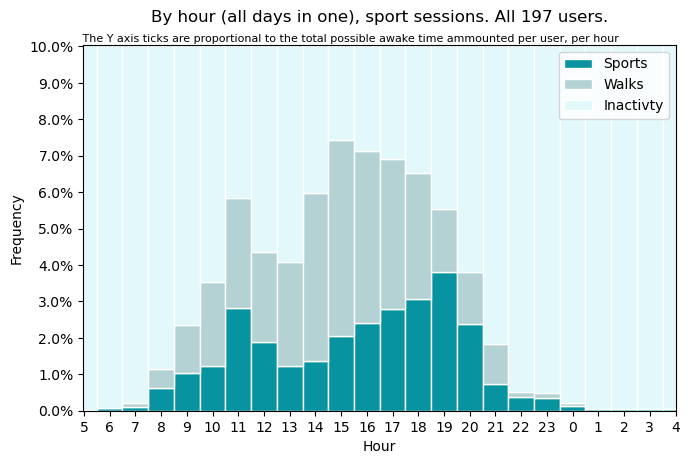

In [144]:
g = results
g['hour'] = g['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks', 'Inactivty'],
        color=("#0893a1", "#b4d1d4", "#e3f8fa")
       )

N = results[results['hour'] == 0].shape[0] - results[results['hour'] == 0].shape[0] * 7/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'By hour (all days in one), sport sessions. All 197 users.', y=1.04)
plt.suptitle("   The Y axis ticks are proportional to the total possible awake time ammounted per user, per hour", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byhour_everyday.png')

plt.show()

# By experiment day, all 197 users 

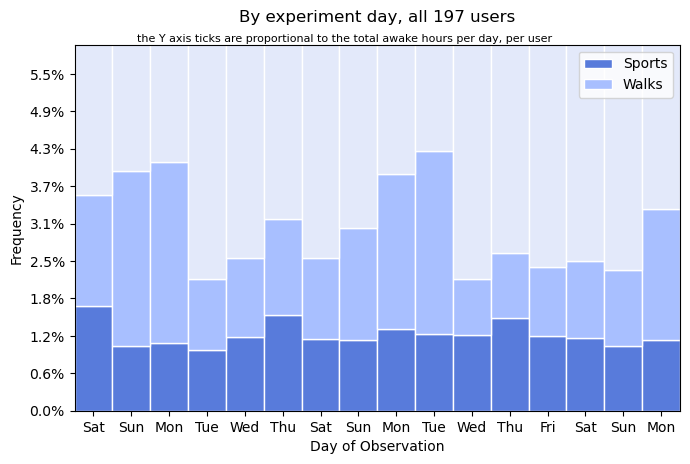

In [230]:
g = results[results.day != 0]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

ax.hist([g['day'][g['what'] == 'Sport'], g['day'][g['what'] == "Walking"], g['day'][g['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(g.day.unique()) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#587bdb", "#a8bfff", "#e3e9fa")
       )

N = results[results['hour'] == 0].shape[0] - results[results['day'] == 0].shape[0] * 7/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
list_of_days = ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu']*2
list_of_days.extend(['Fri', 'Sat', 'Sun', 'Mon', 'Tue'])
plt.xticks(np.arange(1, len(g.day.unique())), list_of_days)
plt.xlabel('Day of Observation')
plt.ylabel('Frequency')
plt.ylim(0, 0.06*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.xlim(0.5,16.5)
#plt.margins(x=-0.01)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'By experiment day, all 197 users', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total awake hours per day, per user", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byexperimentday_everyday.png')

plt.show()

# Lecture days (Monday to Friday) only, all 197 users

/tmp/ipykernel_799646/1123676736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['hour'] = g1['date_not'].dt.hour - 5
/tmp/ipykernel_799646/1123676736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['hour'] = [today_or_yesterday(hour) for hour in g1['hour']]


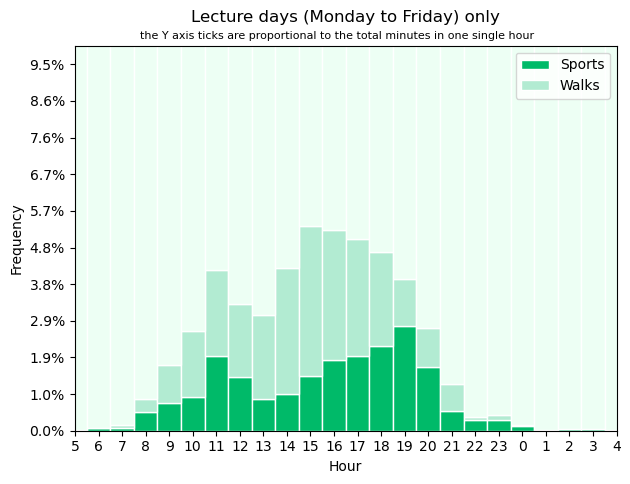

In [248]:
g1 = results[~results.day.isin(weekend_clock_days)]

g1['hour'] = g1['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g1['hour'] = [today_or_yesterday(hour) for hour in g1['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#00ba69", "#b2ebd2", "#edfff4")
       )
       
N = g1[g1.hour==0].shape[0]
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

plt.title(f'Lecture days (Monday to Friday) only', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('lecturedays.png')

plt.show()

# Weekends only, all 197 users

/tmp/ipykernel_799646/4025021726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['hour'] = g2['date_not'].dt.hour - 5
/tmp/ipykernel_799646/4025021726.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['hour'] = [today_or_yesterday(hour) for hour in g['hour']]


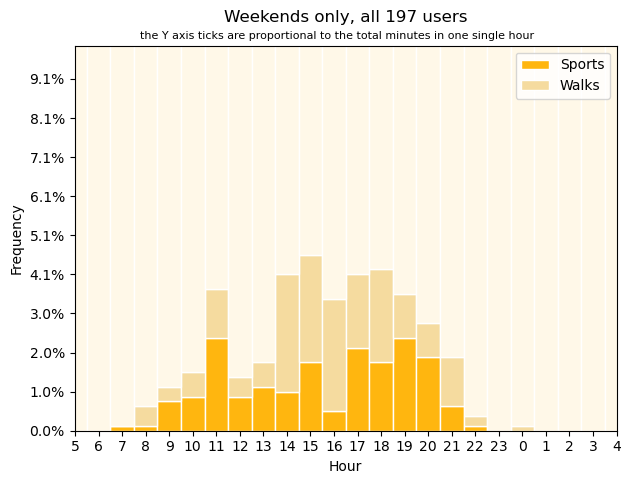

In [249]:
g2 = results[results.day.isin(weekend_clock_days)]

g2['hour'] = g2['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g2['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#ffb60f", "#f5db9f", "#fff8e8")
       )
       
N = g2[g2.hour == 0].shape[0]
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

plt.title(f'Weekends only, all 197 users', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('weekends.png')

plt.show()

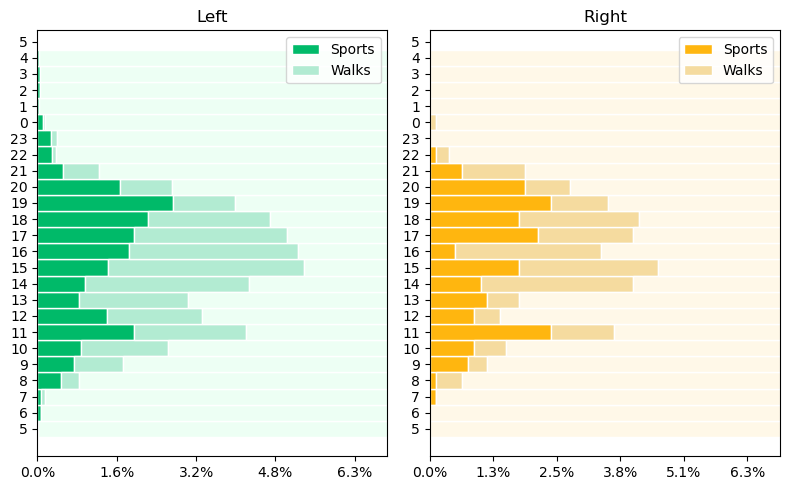

In [294]:
import matplotlib.pyplot as plt
import numpy as np

values1, values2 = [g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']], [g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']]

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 2, 1)  # 2 rows, 1 column, first subplot
ax1.hist(values1,
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         stacked=True,
         edgecolor='white', label=['Sports', 'Walks'],
         color=("#00ba69", "#b2ebd2", "#edfff4"),
         orientation = "horizontal")
N1 = g1[g1['hour'] == 0].shape[0]
ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N1, decimals=1))
ax1.set_title('Left')
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.xlim(0, 0.07*N1)
plt.legend()

# Second subplot
ax2 = fig.add_subplot(1, 2, 2)  # 2 rows, 1 column, second subplot
ax2.hist(values2,
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         stacked=True, edgecolor='white', label=['Sports', 'Walks'],
         color=("#ffb60f", "#f5db9f", "#fff8e8"),
         orientation = "horizontal")
N2 = g2[g2['hour'] == 0].shape[0]
ax2.xaxis.set_major_formatter(PercentFormatter(xmax=N2, decimals=1))
plt.yticks(np.arange(len(custom_order)), custom_order)
ax2.set_title('Right')
plt.xlim(0, 0.07*N2)
plt.legend()

plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]


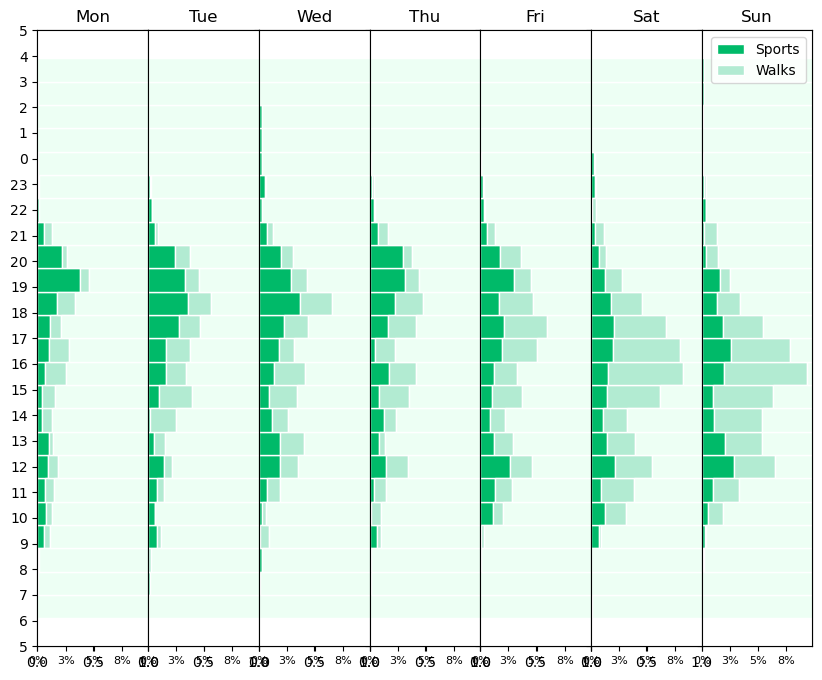

In [437]:
#For every day of the experiment, make one histogram. 
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.xticks([])
all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']]
    ax1 = axs[current_day]
    ax1 = fig.add_subplot(1, len(all_days), current_day +1)
    
    ax1.hist(values,
             bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
             stacked=True,edgecolor='white', label=['Sports', 'Walks'],
             color=("#00ba69", "#b2ebd2", "#edfff4"),
             orientation = "horizontal")
    
    N = g[g['hour'] == 0].shape[0]
    plt.xlim(0, 0.10*N)
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))
    ax1.set_title(f'{weekdays[current_day]}')    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax1.xaxis.set_tick_params(labelsize=8)
    ax1.yaxis.set_visible(False)
    
    
fig.subplots_adjust(wspace=0.0)   
plt.legend()
plt.savefig('a_typical_week.png')
plt.show()


In [363]:
location, company, degree, department, sex

,date_not,id,what,withw,where,day,hour,weekday
803,2020-11-30 05:00:00,0.0,Inactive,NaN,NaN,18,0,Mon
804,2020-11-30 05:30:00,0.0,Inactive,NaN,NaN,18,0,Mon
805,2020-11-30 06:00:00,0.0,Inactive,NaN,NaN,18,1,Mon
806,2020-11-30 06:30:00,0.0,Inactive,NaN,NaN,18,1,Mon
807,2020-11-30 07:00:00,0.0,Inactive,NaN,NaN,18,2,Mon
...,...,...,...,...,...,...,...,...
170201,2020-11-30 21:30:00,266.0,Inactive,NaN,NaN,18,16,Mon
170202,2020-11-30 22:00:00,266.0,Inactive,NaN,NaN,18,17,Mon
170203,2020-11-30 22:30:00,266.0,Inactive,NaN,NaN,18,17,Mon
170204,2020-11-30 23:00:00,266.0,Inactive,NaN,NaN,18,18,Mon
